In [1]:
import numpy as np
import xarray as xr
from pyrte_rrtmgp.rrtmgp import GasOptics
from pyrte_rrtmgp.rrtmgp_data_files import GasOpticsFiles
import myutils.data_helper as dh
import angles


def make_atmosphere(p, T, h2o_vmr, T_s=None):
    """Create a pyRTE-RRTMG atmosphere from pressure, temperature and humidity arrays."""
    if np.any(p[..., 0] < p[..., -1]):
        raise ValueError("Arrays need to be passed in ascending order")

    if T_s is None:
        T_s = T[..., 0]

    atmosphere = xr.Dataset(
        data_vars={
            "pres_level": (("column", "level"), p),
            "temp_level": (("column", "level"), T),
            "pres_layer": (("column", "layer"), 0.5 * (p[..., 1:] + p[..., :-1])),
            "temp_layer": (("column", "layer"), 0.5 * (T[..., 1:] + T[..., :-1])),
            "surface_temperature": (("column",), T_s),
            "h2o": (("column", "layer"), 0.5 * (h2o_vmr[..., 1:] + h2o_vmr[..., :-1])),
            "o3": 0,
            "co2": 348e-6,
            "ch4": 1650e-9,
            "n2o": 306e-9,
            "n2": 0.7808,
            "o2": 0.2095,
            "co": 0.0,
        },
    )

    return atmosphere

In [2]:
ds = xr.open_dataset(
    "ipfs://bafybeiesyutuduzqwvu4ydn7ktihjljicywxeth6wtgd5zi4ynxzqngx4m", engine="zarr"
)
ds = ds.pipe(dh.interpolate_gaps).pipe(dh.extrapolate_sfc)
ds = ds.isel(  # pick every 10th sonde
    altitude=slice(0, 1100),  # skip upper-most layers due to NaN values
).dropna(dim="sonde", how="any", subset=["ta", "q", "p"])
ds = ds.assign(
    mu0=xr.apply_ufunc(
        angles.cos_zenith_angle,
        ds.launch_time,
        ds.launch_lat,
        ds.launch_lon,
        vectorize=True,
    )
)
atmosphere = make_atmosphere(ds.p.values, ds.ta.values, ds.q.values)
atmosphere

<xarray.Dataset> Size: 22MB
Dimensions:              (column: 989, level: 1100, layer: 1099)
Dimensions without coordinates: column, level, layer
Data variables: (12/13)
    pres_level           (column, level) float32 4MB 1.012e+05 ... 2.501e+04
    temp_level           (column, level) float32 4MB 296.4 296.3 ... 234.1 234.1
    pres_layer           (column, layer) float32 4MB 1.011e+05 ... 2.503e+04
    temp_layer           (column, layer) float32 4MB 296.3 296.3 ... 234.2 234.1
    surface_temperature  (column) float32 4kB 296.4 298.6 300.6 ... 302.6 302.6
    h2o                  (column, layer) float32 4MB 0.01527 ... 8.613e-05
    ...                   ...
    co2                  float64 8B 0.000348
    ch4                  float64 8B 1.65e-06
    n2o                  float64 8B 3.06e-07
    n2                   float64 8B 0.7808
    o2                   float64 8B 0.2095
    co                   float64 8B 0.0

In [3]:
gas_optics_lw = GasOptics(gas_optics_file=GasOpticsFiles.LW_G256)
gas_optics_sw = GasOptics(gas_optics_file=GasOpticsFiles.SW_G224)
optical_props = gas_optics_lw.compute(atmosphere, add_to_input=False)

optical_props = optical_props.assign(surface_emissivity=0.98)

In [ ]:
clr_fluxes = optical_props.rte.solve(add_to_input=False)

In [ ]:
optical_props_sw = gas_optics_sw.compute(atmosphere, add_to_input=False)

In [ ]:
optical_props_sw["surface_albedo"] = 0.06
optical_props_sw = optical_props_sw.assign(mu0=("column", ds.mu0.values))
sw_fluxes = optical_props_sw.rte.solve(add_to_input=False)

In [26]:
sw_fluxes

<xarray.Dataset> Size: 26kB
Dimensions:       (column: 1, level: 1100)
Coordinates:
  * column        (column) int64 8B 0
Dimensions without coordinates: level
Data variables:
    sw_flux_up    (column, level) float64 9kB 45.14 45.18 45.22 ... 86.08 86.1
    sw_flux_down  (column, level) float64 9kB 752.3 752.6 752.8 ... 975.0 976.0
    sw_flux_dir   (column, level) float64 9kB 706.2 706.5 706.8 ... 974.9 976.0

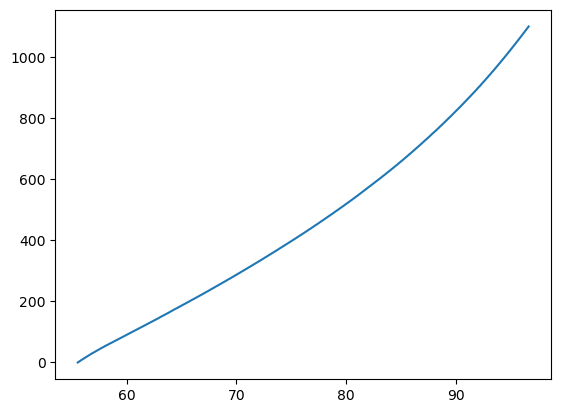

In [13]:
import matplotlib.pyplot as plt

plt.plot(
    sw_fluxes.sw_flux_up.isel(column=0),
    sw_fluxes.level,
)